<a href="https://colab.research.google.com/github/fernandallobao/ML_salarios/blob/main/analise_salario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##__Problem 3: Regression Analysis__

A supermarket company has a new internal policy to not discriminate significantly salary according to the location of their employees. They gathered the data from all of their employees and want you to verify if they are already following the new policy.
Before answering the questions below take a look at the annexed dataset: (1stPhase-SelectiveProcess-Data Science-Data Base.csv)

### A. Describe how can you use the supermarket data to verify if employees from different locations have significantly different salaries. (Include here how you are going to treat the variables before feeding into the model)

### B. Implement the approach you described in Python or r.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the libraries that will be used and viewing the first few lines.

In [ ]:
# WRITE YOUR CODE HERE

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind
import statsmodels.api as sm

df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/case artefact/1st_Phase_-_Selective_Process_-_Data_Science_-_DataBase.xlsx')
df.head()

,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
0,1,SECUNDÁRIO,GERENTE,INTERIOR,30,1,4279.5
1,2,SUPERIOR,AUXILIAR,INTERIOR,32,4,4575.4
2,3,SECUNDÁRIO,AUXILIAR,CAPITAL,33,2,4735.6
3,4,SUPERIOR,GERENTE,INTERIOR,34,3,4863.1
4,5,SECUNDÁRIO,GERENTE,INTERIOR,36,1,5355.8


Exploring the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              80 non-null     int64  
 1   EDUCAÇÃO        80 non-null     object 
 2   CARGO           80 non-null     object 
 3   LOCAL           80 non-null     object 
 4   IDADE           80 non-null     int64  
 5   TEMPOCASA       80 non-null     int64  
 6   SALARIO_MENSAL  80 non-null     float64
dtypes: float64(1), int64(3), object(3)
memory usage: 4.5+ KB


Checking the data by groups.

In [ ]:
#explorando os dados
cargos = df.groupby(df.CARGO).size()
educacao = df.groupby(df.EDUCAÇÃO).size()
localidade = df.groupby(df.LOCAL).size()
print(localidade)
print(educacao)
print(cargos)

LOCAL
CAPITAL     45
INTERIOR    35
dtype: int64
EDUCAÇÃO
SECUNDÁRIO    15
SUPERIOR      65
dtype: int64
CARGO
AUXILIAR    37
DIRETOR     13
GERENTE     30
dtype: int64


Checking the SALARIO_MENSAL column, which will be the main focus of the analysis.

In [ ]:
df.SALARIO_MENSAL.describe()

,SALARIO_MENSAL
count,80.000000
mean,5777.622500
std,1138.187752
min,4186.600000
25%,4894.300000
50%,5673.450000
75%,6306.300000
max,12465.800000


Viewing the distribution of salaries by location.


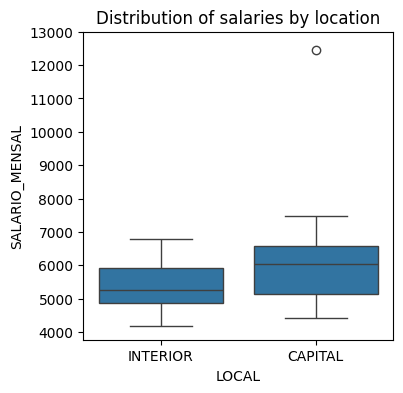

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='LOCAL', y='SALARIO_MENSAL', data=df)
plt.title('Distribution of salaries by location')
plt.yticks(np.arange(4000, 14000, 1000))
plt.show()

By analyzing the graph, we can already see that there is indeed a difference in salary by location. The maximum and minimum salaries in the capital are higher than those in the countryside, not to mention the outlier of approximately 12500.


Dropping the ID column since it will not be relevant for the analysis.

In [ ]:
#DROPANDO A COLUNA id
df.drop('ID', axis=1, inplace=True)

Converting the categorical variables (EDUCAÇÃO, CARGO, LOCAL) into dummy variables so they can be used in ML models.

In [ ]:
df = pd.get_dummies(df, columns=['EDUCAÇÃO',	'CARGO'	,'LOCAL'])
df = df.astype(int)
df.head()

,IDADE,TEMPOCASA,SALARIO_MENSAL,EDUCAÇÃO_SECUNDÁRIO,EDUCAÇÃO_SUPERIOR,CARGO_AUXILIAR,CARGO_DIRETOR,CARGO_GERENTE,LOCAL_CAPITAL,LOCAL_INTERIOR
0,30,1,4279,1,0,0,0,1,0,1
1,32,4,4575,0,1,1,0,0,0,1
2,33,2,4735,1,0,1,0,0,1,0
3,34,3,4863,0,1,0,0,1,0,1
4,36,1,5355,1,0,0,0,1,0,1


The matrix was created to understand the relationships between the numerical variables. Since we are checking the salaries at the end, we can see how the other columns relate to them.

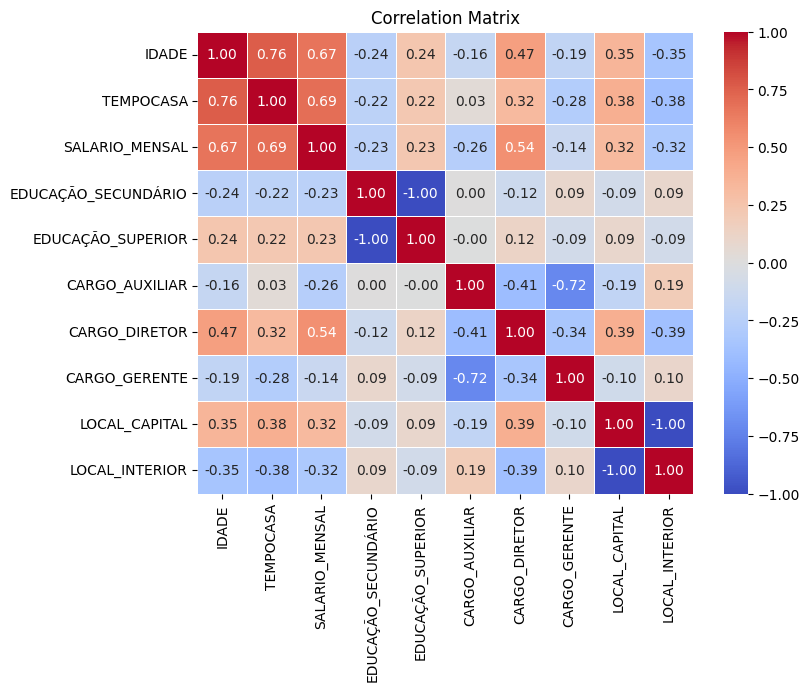

SALARIO_MENSAL         1.000000
TEMPOCASA              0.689184
IDADE                  0.670947
CARGO_DIRETOR          0.540287
LOCAL_CAPITAL          0.318752
EDUCAÇÃO_SUPERIOR      0.230937
CARGO_GERENTE         -0.144863
EDUCAÇÃO_SECUNDÁRIO   -0.230937
CARGO_AUXILIAR        -0.259100
LOCAL_INTERIOR        -0.318752
Name: SALARIO_MENSAL, dtype: float64


In [ ]:
# Criar matriz de correlação
correlation_matrix = df.corr(numeric_only=True)

# Plotar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Adicionar título
plt.title('Correlation Matrix')

# Exibir o gráfico
plt.show()

# Exibir apenas as correlações com SALARIO_MENSAL
print(correlation_matrix['SALARIO_MENSAL'].sort_values(ascending=False))

We can observe that the variables IDADE, TEMPO_CASA and SALARIO_MENSAL are strongly correlated with each other. This suggests that these variables may be capturing similar information.

Normalization of the data

It was determined that some columns needed to be normalized to ensure that all variables were on the same scale as the remaining columns.

In [ ]:
#NORMALIZAÇÃO
scaler = StandardScaler()
df[['SALARIO_MENSAL', 'TEMPOCASA', 'IDADE']] = scaler.fit_transform(df[['SALARIO_MENSAL', 'TEMPOCASA', 'IDADE']])
df.head()

,IDADE,TEMPOCASA,SALARIO_MENSAL,EDUCAÇÃO_SECUNDÁRIO,EDUCAÇÃO_SUPERIOR,CARGO_AUXILIAR,CARGO_DIRETOR,CARGO_GERENTE,LOCAL_CAPITAL,LOCAL_INTERIOR
0,-2.071359,-1.344276,-1.324628,1,0,0,0,1,0,1
1,-1.861601,-0.936405,-1.062919,0,1,1,0,0,0,1
2,-1.756722,-1.208319,-0.921454,1,0,1,0,0,1,0
3,-1.651843,-1.072362,-0.808283,0,1,0,0,1,0,1
4,-1.442085,-1.344276,-0.373279,1,0,0,0,1,0,1


Multivariate Linear Regression

This type of model was chosen because it allows for the correlation of the columns LOCAL_CAPITAL, IDADE, and TEMPO_CASA, as they have shown a high degree of relationship with the SALARIO_MENSAL column. LOCAL_INTERIOR was not included since it provides the same type of information as LOCAL_CAPITAL.


In [ ]:
X = df[['LOCAL_CAPITAL', 'IDADE', 'TEMPOCASA']]
y = df['SALARIO_MENSAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Verificar significância do coeficiente de LOCAL_CAPITAL
X = sm.add_constant(X)
model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())

# Teste t para comparar médias salariais
salario_capital = df[df['LOCAL_CAPITAL'] == 1]['SALARIO_MENSAL']
salario_interior = df[df['LOCAL_INTERIOR'] == 1]['SALARIO_MENSAL']
t_stat, p_value = ttest_ind(salario_capital, salario_interior)
print(f"Estatística t: {t_stat}")
print(f"Valor-p: {p_value}")


                            OLS Regression Results                            
Dep. Variable:         SALARIO_MENSAL   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     28.19
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           2.34e-12
Time:                        23:37:59   Log-Likelihood:                -83.596
No. Observations:                  80   AIC:                             175.2
Df Residuals:                      76   BIC:                             184.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0464      0.125     -0.370

#Conclusion:
- The MSE = 1.9026 indicates that the model is making predictions close to the actual value.

- The coefficient of IDADE = 0.3416 suggests that each year of age is associated with an increase of approximately 0.3416 units in monthly salary.

- The coefficient of TEMPO_CASA = 0.4127 suggests that each year of tenure is associated with an increase of 0.4127 units in monthly salary.

- Considering R-squared = 0.527, it indicates that the model explains 52% of the variation in the dependent variable.

- t = 2.97 indicates the magnitude of the difference between the salary averages of LOCAL_CAPITAL and LOCAL_INTERIOR.

- p-value = 0.0039 < 0.05 indicates that there is a statistically significant difference between the salaries of the two locations.

#Final Considerations:
- Considering the information and the model as it is, it could still be improved, but there is a difference between local salaries.

- The outlier observed in the SALARIO_MENSAL column may be influencing the results.

- I believe that if there were more explanatory variables in the model, it would be possible to capture more variability in salaries.




---

